## Statistics of diagnostics

This notebook compares the statistics of diagnostics simulated by different schemes with atmospheric forcing from JRA55-do.
This example plots the January monthly mean mixed layer depth (MLD).

In [1]:
import sys
import os
sys.path.append(os.environ['GOTMWORK_ROOT']+'/tools', )
from gotmanalysis import *
%matplotlib inline

In [2]:
# parameters
casename = 'JRA55-do_Global_dampV5d_3h_r4'
diagname = 'mld_deltaR_mean'
diag_type = 'R'
# diag_type = 'D'

In [3]:
# diagnostics
if diag_type == 'D':
    y_ref = 0
    y_label = '$\Delta$'
    if diagname == 'mld_deltaR_mean':
        ymin = -20
        ymax = 60
    elif diagname == 'mld_deltaRp1_mean':
        ymin = -20
        ymax = 60
    elif diagname == 'PE_delta':
        ymin = -2e4
        ymax = 2e4
    elif diagname == 'SST_mean':
        ymin = -0.6
        ymax = 0.3
    else:
        raise ValueError('Diagnostics \'{}\' not supported. Stop.'.format(diagname))
elif diag_type == 'R':
    y_ref = 1
    y_label = '$R$'
    if diagname == 'mld_deltaR_mean':
        ymin = 0.65
        ymax = 1.56
    elif diagname == 'mld_deltaRp1_mean':
        ymin = 0.65
        ymax = 1.55
    elif diagname == 'PE_delta':
        ymin = 0.6
        ymax = 1.6
    elif diagname == 'SST_mean':
        ymin = 0.9
        ymax = 1.1
    else:
        raise ValueError('Diagnostics \'{}\' not supported. Stop.'.format(diagname))
else:
    raise ValueError('Diagnostics type \'{}\' not supported. Stop.'.format(diag_type))

# prefix of figure
fig_prefix = 'stat_diag_'+diag_type

In [4]:
# paths
s2data_root = os.environ['GOTMFIG_ROOT']+'/data/'+casename
fig_root = os.environ['GOTMFIG_ROOT']+'/'+casename+'/stat'
os.makedirs(s2data_root, exist_ok=True)
os.makedirs(fig_root, exist_ok=True)

In [5]:
# lists
timetag_list = ['20090101-20090131',
                '20090201-20090228',
                '20090301-20090331',
                '20090401-20090430',
                '20090501-20090531',
                '20080601-20080630',
                '20080701-20080731',
                '20080801-20080831',
                '20080901-20080930',
                '20081001-20081031',
                '20081101-20081130',
                '20081201-20081231']
ntag = len(timetag_list)
turbmethod_list = ['KPP-CVMix',
                   'KPP-ROMS',
                   'EPBL-RH18',
                   'SMC',
                   'K-EPSILON-SG',
                   'KPPLT-EFACTOR',
                   'KPPLT-ENTR',
                   'KPPLT-RWHGK',
                   'EPBL-RL19',
                   'SMCLT',
                   'OSMOSIS']
legend_list = ['KPP-CVMix',
               'KPP-ROMS',
               'ePBL',
               'SMC-KC94',
               '$k$-$\epsilon$-SG95',
               'KPPLT-VR12',
               'KPPLT-LF17',
               'KPPLT-R16',
               'ePBL-LT',
               'SMCLT-H15',
               'OSMOSIS']
nm = len(turbmethod_list)
bcolor = ['lightcyan','lightblue','greenyellow','lightpink','palegoldenrod',
          'turquoise', 'deepskyblue','royalblue','forestgreen','firebrick','mediumpurple']
idx_kpp_cvmix = 0
idx_epbl = 2
idx_smc_kc94 = 3
idx_kpplt_lf17 = 6
idx_epbllt = 8
idx_smclt_h15 = 9

In [6]:
# get data and save in a two dimensional list
gmobj_data_arr = []
gmobj_freg_mon = []
for j in np.arange(ntag):
    timetag = timetag_list[j]
    # read forcing regime
    s2data_name = s2data_root+'/VR1m_DT600s_'+timetag+ \
                  '/data_map_forcing_regime_BG12_KPP-CVMix.npz'
    gmobj_tmp = GOTMMap().load(s2data_name)
    gmobj_freg_mon.append(gmobj_tmp)
    # read data
    gmobj_data_tmp = []
    for i in np.arange(nm):
        tmname = turbmethod_list[i]
        s2data_name = s2data_root+'/VR1m_DT600s_'+timetag+'/data_map_'+ \
                      diagname+'_'+tmname+'.npz'
        gmobj_tmp = GOTMMap().load(s2data_name)
        gmobj_data_tmp.append(gmobj_tmp)
    gmobj_data_arr.append(gmobj_data_tmp)

In [7]:
# mean (over all non-Langmuir turbulent methods) of diagname at each month, [12]*GOTMMap
gmobj_m_mon_nlt = []
gmobj_m_mon_lt = []
# ratio of diagname for each turbulent methods over the median, [12][11]*GOTMMap
gmobj_stat_arr = []
gmobj_m_mon_kpp = []
gmobj_m_mon_epbl = []
gmobj_m_mon_smc = []
# loop over time tags
for j in np.arange(ntag):
    ncase = gmobj_data_arr[j][0].data.size
    tmp = np.zeros([nm, ncase])
    # loop over turbulent methods
    for i in np.arange(nm):
        tmp[i,:] = gmobj_data_arr[j][i].data
    # mean of all non-Langmuir cases
    diag0_nlt = np.nanmean(tmp[0:5,:], axis=0)
    diag0_lt = np.nanmean(tmp[5:], axis=0)
    # get lon, lat etc.
    lon = gmobj_data_arr[j][0].lon
    lat = gmobj_data_arr[j][0].lat
    name = gmobj_data_arr[j][0].name
    units = gmobj_data_arr[j][0].units
    # diagnostics
    if diag_type == 'D':
        # difference
        diag1_nlt = diag0_nlt - diag0_nlt
        diag1_lt = diag0_lt - diag0_nlt
        diag1_kpp = tmp[idx_kpplt_lf17,:] - tmp[idx_kpp_cvmix,:]
        diag1_epbl = tmp[idx_epbllt,:] - tmp[idx_epbl,:]
        diag1_smc = tmp[idx_smclt_h15,:] - tmp[idx_smc_kc94,:]
    elif diag_type == 'R':
        # ratio
        diag1_nlt = diag0_nlt / diag0_nlt
        diag1_lt = diag0_lt / diag0_nlt
        diag1_kpp = tmp[idx_kpplt_lf17,:] / tmp[idx_kpp_cvmix,:]
        diag1_epbl = tmp[idx_epbllt,:] / tmp[idx_epbl,:]
        diag1_smc = tmp[idx_smclt_h15,:] / tmp[idx_smc_kc94,:]
    # create GOTMMap object
    gmobj_tmp_nlt = GOTMMap(data=diag1_nlt, lon=lon, lat=lat, name=name, units=units)
    gmobj_tmp_lt = GOTMMap(data=diag1_lt, lon=lon, lat=lat, name=name, units=units)
    gmobj_tmp_kpp = GOTMMap(data=diag1_kpp, lon=lon, lat=lat, name=name, units=units)
    gmobj_tmp_epbl = GOTMMap(data=diag1_epbl, lon=lon, lat=lat, name=name, units=units)
    gmobj_tmp_smc = GOTMMap(data=diag1_smc, lon=lon, lat=lat, name=name, units=units)
    # append to list
    gmobj_m_mon_nlt.append(gmobj_tmp_nlt)
    gmobj_m_mon_lt.append(gmobj_tmp_lt)
    gmobj_m_mon_kpp.append(gmobj_tmp_kpp)
    gmobj_m_mon_epbl.append(gmobj_tmp_epbl)
    gmobj_m_mon_smc.append(gmobj_tmp_smc)
    # tmp list
    gmobj_stat_tmp = []
    # loop over turbulent methods
    for i in np.arange(nm):
        if diag_type == 'D':
            # difference
            diag1 = tmp[i,:] - diag0_nlt
        elif diag_type == 'R':
            # ratio
            diag1 = tmp[i,:] / diag0_nlt
        # create GOTMMap object
        gmobj_tmp = GOTMMap(data=diag1, lon=lon, lat=lat, name=name, units=units)
        # append to list
        gmobj_stat_tmp.append(gmobj_tmp)
    # append to list
    gmobj_stat_arr.append(gmobj_stat_tmp)

/Users/qingli/miniconda3/envs/gotm/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/Users/qingli/miniconda3/envs/gotm/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


Max for KPPLT-R16: 1.51
Min for OSMOSIS: 0.71
Standard deviation of non-Langmuir: 0.0584
Standard deviation of Langmuir: 0.1460


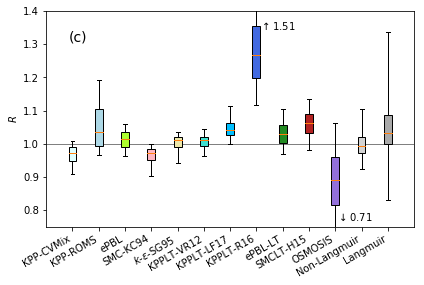

In [8]:
# figure 1: Statistics of the ratio to the median or mean
f = plt.figure()
f.set_size_inches(6, 4)

pbdata0 = []
xshift = list((np.arange(nm)-nm/2)*1)
for k in np.arange(nm):
    pdata = np.concatenate([gmobj_stat_arr[i][k].data for i in np.arange(12)])
    tmp = pdata
    pdata0 = pdata[~np.isnan(tmp)]
    pbdata0.append(pdata0)

# all the non-Langmuir cases
pdata1 = np.concatenate(pbdata0[0:5])
# all the Langmuir cases
pdata2 = np.concatenate(pbdata0[5:])
pbdata0.append(pdata1)
pbdata0.append(pdata2)
    
# add color for non-Lanmguir and Langmuir cases
pbcolor = bcolor
pbcolor.append('lightgray')
pbcolor.append('darkgray')
# add label for non-Lanmguir and Langmuir cases
label_list = legend_list
label_list.append('Non-Langmuir')
label_list.append('Langmuir')

# reference line
plt.axhline(y=y_ref, linewidth=1, color='gray')

# plot
xx = np.arange(nm+2)+1
position_arr = xx
pbox0 = plt.boxplot(pbdata0, whis=[5, 95], showfliers=False, positions=position_arr,
                         widths=0.3, patch_artist=True)
tmp_arr = [item.get_ydata() for item in pbox0['whiskers']]
label_b = tmp_arr[20][1]
label_a = tmp_arr[15][1]
plt.xlim([0,nm+3])
ax = plt.gca()
if diag_type == 'D':
    ylims = [-13,32]
    panel = '(a)'
    label_a_str = r'$\uparrow${:4.1f}'.format(label_a)
    label_b_str = r'$\downarrow${:4.1f}'.format(label_b)
elif diag_type == 'R':
    ylims = [0.75,1.4]
    panel = '(c)'
    label_a_str = r'$\uparrow${:4.2f}'.format(label_a)
    label_b_str = r'$\downarrow${:4.2f}'.format(label_b)
plt.ylim(ylims)
if label_a > ylims[1]:
    plt.text(0.58, 0.96, label_a_str, transform=ax.transAxes,
             fontsize=10, color='k', va='top')
if label_b < ylims[0]:
    plt.text(0.79, 0.07, label_b_str, transform=ax.transAxes,
             fontsize=10, color='k', va='top')
plt.text(0.06, 0.91, panel, transform=ax.transAxes, fontsize=14, color='k', va='top')
        
# color for the  boxes
for patch, color in zip(pbox0['boxes'], pbcolor):
    patch.set_facecolor(color)
    
# x- and y-labels
plt.setp(ax, xticks=xx, xticklabels=label_list)
plt.ylabel(y_label)


# reduce margin
plt.tight_layout()

# auto adjust the x-axis label
plt.gcf().autofmt_xdate()

# save figure
figname = fig_root+'/'+fig_prefix+'_'+diagname+'_all.png'
plt.savefig(figname, dpi = 300)

# print info
print('Max for KPPLT-R16: {:4.2f}'.format(label_a))
print('Min for OSMOSIS: {:4.2f}'.format(label_b))
print('Standard deviation of non-Langmuir: {:6.4f}'.format(np.std(pdata1)))
print('Standard deviation of Langmuir: {:6.4f}'.format(np.std(pdata2)))

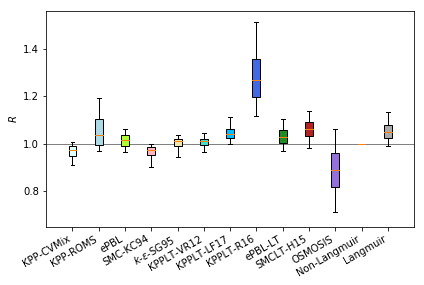

In [9]:
# figure 1b: Statistics of the ratio to the median or mean
# mean of all non-Langmuir and Langmuir cases, respectivly 
f = plt.figure()
f.set_size_inches(6, 4)

pbdata0 = []
xshift = list((np.arange(nm)-nm/2)*1)
for k in np.arange(nm):
    pdata = np.concatenate([gmobj_stat_arr[i][k].data for i in np.arange(12)])
    tmp = pdata
    pdata0 = pdata[~np.isnan(tmp)]
    pbdata0.append(pdata0)

# mean of the non-Langmuir cases
pdata = np.concatenate([gmobj_m_mon_nlt[i].data for i in np.arange(12)])
tmp = pdata
pdata1 = pdata[~np.isnan(tmp)]
# mean of the Langmuir cases
pdata = np.concatenate([gmobj_m_mon_lt[i].data for i in np.arange(12)])
tmp = pdata
pdata2 = pdata[~np.isnan(tmp)]
pbdata0.append(pdata1)
pbdata0.append(pdata2)
    
# add color for non-Lanmguir and Langmuir cases
pbcolor = bcolor
pbcolor.append('lightgray')
pbcolor.append('darkgray')
# add label for non-Lanmguir and Langmuir cases
label_list = legend_list
label_list.append('Non-Langmuir')
label_list.append('Langmuir')

# reference line
plt.axhline(y=y_ref, linewidth=1, color='gray')

# plot
xx = np.arange(nm+2)+1
position_arr = xx
pbox0 = plt.boxplot(pbdata0, whis=[5, 95], showfliers=False, positions=position_arr,
                    widths=0.3, patch_artist=True)
plt.ylim([ymin,ymax])
plt.xlim([0,nm+3])

# color for the  boxes
for patch, color in zip(pbox0['boxes'], pbcolor):
    patch.set_facecolor(color)
    
# x- and y-labels
ax = plt.gca()
plt.setp(ax, xticks=xx, xticklabels=label_list)
plt.ylabel(y_label)

# reduce margin
plt.tight_layout()

# auto adjust the x-axis label
plt.gcf().autofmt_xdate()

# save figure
figname = fig_root+'/'+fig_prefix+'_'+diagname+'_all_b.png'
plt.savefig(figname, dpi = 300)

KPPLT-LF17:
    Mean: 1.08
    Median: 1.07
    50% range: 1.05 - 1.11
    90% range: 1.02 - 1.18
ePBL-LT:
    Mean: 1.02
    Median: 1.01
    50% range: 1.00 - 1.03
    90% range: 1.00 - 1.07
SMCLT-H15:
    Mean: 1.10
    Median: 1.10
    50% range: 1.06 - 1.13
    90% range: 1.02 - 1.19
Langmuir:
    Mean: 1.05
    Median: 1.05
    50% range: 1.02 - 1.08
    90% range: 0.99 - 1.13


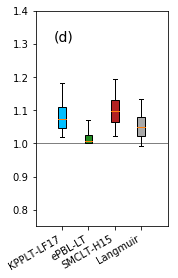

In [10]:
# figure 1c: Statistics of the ratio to the median or mean
# Ratio of Langmuir over non-Langmuir for KPP, ePBL and SMC, and mean of all
f = plt.figure()
f.set_size_inches(2.5, 4)

pbdata0 = []
xshift = list((np.arange(4)*1))

# Langmuir effects in KPP
pdata = np.concatenate([gmobj_m_mon_kpp[i].data for i in np.arange(12)])
tmp = pdata
pdata1 = pdata[~np.isnan(tmp)]
# Langmuir effects in ePBL
pdata = np.concatenate([gmobj_m_mon_epbl[i].data for i in np.arange(12)])
tmp = pdata
pdata2 = pdata[~np.isnan(tmp)]
# Langmuir effects in SMC
pdata = np.concatenate([gmobj_m_mon_smc[i].data for i in np.arange(12)])
tmp = pdata
pdata3 = pdata[~np.isnan(tmp)]
# mean of the Langmuir cases
pdata = np.concatenate([gmobj_m_mon_lt[i].data for i in np.arange(12)])
tmp = pdata
pdata4 = pdata[~np.isnan(tmp)]
pbdata0.append(pdata1)
pbdata0.append(pdata2)
pbdata0.append(pdata3)
pbdata0.append(pdata4)
    
# add color for non-Lanmguir and Langmuir cases
pbcolor = ['deepskyblue','forestgreen','firebrick','darkgray']
# add label for non-Lanmguir and Langmuir cases
label_list = ['KPPLT-LF17', 'ePBL-LT', 'SMCLT-H15', 'Langmuir']

# reference line
plt.axhline(y=y_ref, linewidth=1, color='gray')

# plot
xx = np.arange(4)+1
position_arr = xx
pbox0 = plt.boxplot(pbdata0, whis=[5, 95], showfliers=False, positions=position_arr,
                    widths=0.3, patch_artist=True)
plt.xlim([0,5])
ax = plt.gca()
if diag_type == 'D':
    plt.ylim([-12,32])
    plt.text(0.14, 0.91, '(b)', transform=ax.transAxes, fontsize=14, color='k', va='top')
    # label
elif diag_type == 'R':
    plt.ylim([0.75,1.4])
    plt.text(0.14, 0.91, '(d)', transform=ax.transAxes, fontsize=14, color='k', va='top')


# color for the  boxes
for patch, color in zip(pbox0['boxes'], pbcolor):
    patch.set_facecolor(color)
    
# x- and y-labels
plt.setp(ax, xticks=xx, xticklabels=label_list)
# plt.ylabel(y_label+'$^\prime$')

# reduce margin
plt.tight_layout()

# auto adjust the x-axis label
plt.gcf().autofmt_xdate()

# save figure
figname = fig_root+'/'+fig_prefix+'_'+diagname+'_all_c.png'
plt.savefig(figname, dpi = 300)

# print info
medians_arr = [item.get_ydata() for item in pbox0['medians']]
whiskers_arr = [item.get_ydata() for item in pbox0['whiskers']]
for i, var in enumerate(label_list):
    print('{}:'.format(var))
    print('    Mean: {:4.2f}'.format(pbdata0[i].mean()))
    print('    Median: {:4.2f}'.format(medians_arr[i][0]))
    ii = i*2
    print('    50% range: {:4.2f} - {:4.2f}'.format(whiskers_arr[ii][0], whiskers_arr[ii+1][0]))
    print('    90% range: {:4.2f} - {:4.2f}'.format(whiskers_arr[ii][1], whiskers_arr[ii+1][1]))

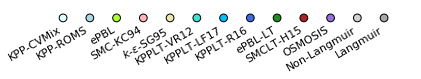

In [11]:
# figure 1d: Legend
f = plt.figure()
f.set_size_inches(6, 1.2)

# add color for non-Lanmguir and Langmuir cases
pbcolor = bcolor
pbcolor.append('lightgray')
pbcolor.append('darkgray')
# add label for non-Lanmguir and Langmuir cases
label_list = legend_list
label_list.append('Non-Langmuir')
label_list.append('Langmuir')

# plot
xx = np.arange(nm+2)+1
yy = np.ones(xx.size)
sct = plt.scatter(xx, yy, s=60, c=pbcolor, edgecolors='k')
plt.xlim([0,nm+3])
for i in np.arange(nm+2):
    plt.text(xx[i], yy[i]-0.05, label_list[i], color='black', 
             fontsize=11, rotation=30, va='top', ha='right')

# x- and y-labels
ax = plt.gca()
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
# plt.setp(ax, xticks=xx, xticklabels=label_list)

# reduce margin
plt.tight_layout()

# auto adjust the x-axis label
plt.gcf().autofmt_xdate()
plt.gcf().subplots_adjust(bottom=0.65)
plt.gcf().subplots_adjust(left=0.1)

# save figure
figname = fig_root+'/legend.png'
plt.savefig(figname, dpi = 300)

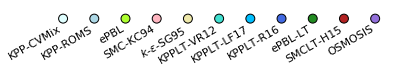

In [12]:
# figure 1e: Legend2
f = plt.figure()
f.set_size_inches(6, 1.2)

# plot
xx = np.arange(nm)+1
yy = np.ones(xx.size)
sct = plt.scatter(xx, yy, s=80, c=bcolor, edgecolors='k', linewidth=1)
plt.xlim([0,nm+1])
for i in np.arange(nm):
    plt.text(xx[i], yy[i]-0.05, legend_list[i], color='black', 
             fontsize=11, rotation=30, va='top', ha='right')

# x- and y-labels
ax = plt.gca()
ax.spines['bottom'].set_color('white')
ax.spines['top'].set_color('white') 
ax.spines['right'].set_color('white')
ax.spines['left'].set_color('white')
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)

# reduce margin
plt.tight_layout()

# auto adjust the x-axis label
plt.gcf().autofmt_xdate()
plt.gcf().subplots_adjust(bottom=0.65)
plt.gcf().subplots_adjust(left=0.1)

# save figure
figname = fig_root+'/legend_2.png'
plt.savefig(figname, dpi = 300)

In [13]:
def mask_forcing_regime(pdata, pfreg):
    hist = np.zeros(14)
    pdata_S0= pdata[pfreg==1]
    pdata_S1 = pdata[pfreg==-1]
    hist[0] = pdata_S0.size
    hist[1] = pdata_S1.size
    pdata_L0= pdata[pfreg==2]
    pdata_L1 = pdata[pfreg==-2]
    hist[2] = pdata_L0.size
    hist[3] = pdata_L1.size
    pdata_C0= pdata[pfreg==3]
    pdata_C1 = pdata[pfreg==-3]
    hist[4] = pdata_C0.size
    hist[5] = pdata_C1.size
    pdata_SL0= pdata[pfreg==4]
    pdata_SL1 = pdata[pfreg==-4]
    hist[6] = pdata_SL0.size
    hist[7] = pdata_SL1.size
    pdata_SC0 = pdata[pfreg==5]
    pdata_SC1 = pdata[pfreg==-5]
    hist[8] = pdata_SC0.size
    hist[9] = pdata_SC1.size
    pdata_LC0 = pdata[pfreg==6]
    pdata_LC1 = pdata[pfreg==-6]
    hist[10] = pdata_LC0.size
    hist[11] = pdata_LC1.size
    pdata_SLC0 = pdata[pfreg==7]
    pdata_SLC1 = pdata[pfreg==-7]
    hist[12] = pdata_SLC0.size
    hist[13] = pdata_SLC1.size
    masked_data = [pdata_S0, pdata_S1, pdata_L0, pdata_L1, pdata_C0, pdata_C1, \
                   pdata_SL0, pdata_SL1, pdata_SC0, pdata_SC1, pdata_LC0, pdata_LC1, \
                   pdata_SLC0, pdata_SLC1]
    hist_pct = hist/np.sum(hist)*100
    return masked_data, hist_pct

[0.00000000e+00 0.00000000e+00 2.11875843e+00 7.38191633e+00
 6.18533513e+00 1.14889789e+01 4.49842555e-03 3.01394512e-01
 1.34952767e-01 1.90283401e+00 3.90733243e+01 2.78902384e+01
 9.89653621e-02 3.41880342e+00]


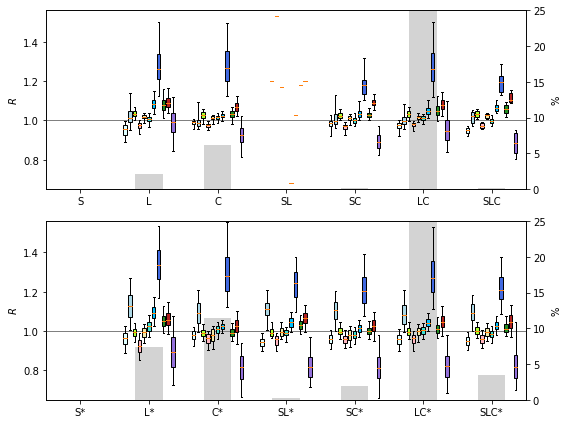

In [14]:
# figure 2: sort the differences by forcing regime

# forcing regimes
pfreg = np.concatenate([gmobj_freg_mon[i].data for i in np.arange(12)])

f, axarr = plt.subplots(2)
f.set_size_inches(8, 6)

# reference line
axarr[0].axhline(y=y_ref, linewidth=1, color='gray')
axarr[1].axhline(y=y_ref, linewidth=1, color='gray')

xshift = list((np.arange(nm)-nm/2)*0.07+0.035)
for k in np.arange(nm):
    pdata = np.concatenate([gmobj_stat_arr[i][k].data for i in np.arange(12)])
    tmp = pdata
    pfreg0 = pfreg[~np.isnan(tmp)]
    pdata0 = pdata[~np.isnan(tmp)]
    if k == 0:
        pbdata0, hist_pct = mask_forcing_regime(pdata0, pfreg0)
    else:
        pbdata0, tmp = mask_forcing_regime(pdata0, pfreg0)
    xx = np.arange(hist_pct.size/2)+1
    position_arr = xx+xshift[k]
    pbox0 = axarr[0].boxplot(pbdata0[0::2], whis=[5, 95], showfliers=False,
                             positions=position_arr, widths=0.05, patch_artist=True)
    pbox1 = axarr[1].boxplot(pbdata0[1::2], whis=[5, 95], showfliers=False,
                             positions=position_arr, widths=0.05, patch_artist=True)
    for patch in pbox0['boxes']:
        patch.set_facecolor(bcolor[k])
    for patch in pbox1['boxes']:
        patch.set_facecolor(bcolor[k])

# x- and y-labels
plt.setp(axarr[0], xticks=xx,
         xticklabels=['S', 'L', 'C', 'SL', 'SC', 'LC', 'SLC'])
plt.setp(axarr[1], xticks=xx,
         xticklabels=['S*','L*','C*','SL*','SC*','LC*', 'SLC*'])
axarr[0].set_ylabel(y_label)
axarr[1].set_ylabel(y_label)
axarr[0].set_xlim([0.5,np.max(xx)+0.5])
axarr[1].set_xlim([0.5,np.max(xx)+0.5])
axarr[0].set_ylim([ymin,ymax])
axarr[1].set_ylim([ymin,ymax])

# frequency of occurrence
par1 = axarr[0].twinx()
par1.bar(xx, hist_pct[0::2], width=0.4, color='lightgray')
par1.set_ylabel('$\%$')
par1.set_ylim([0, 25])
axarr[0].set_zorder(par1.get_zorder()+1)
axarr[0].patch.set_visible(False)

par2 = axarr[1].twinx()
par2.bar(xx, hist_pct[1::2], width=0.4, color='lightgray')
par2.set_ylabel('$\%$')
par2.set_ylim([0, 25])
axarr[1].set_zorder(par2.get_zorder()+1)
axarr[1].patch.set_visible(False)

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/'+fig_prefix+'_'+diagname+'_forc_reg.png'
plt.savefig(figname, dpi = 300)
print(hist_pct)

Percentage of each regime:
    L:   2.12%,  LC:  39.07%,  C:   6.19%
   L*:   7.38%, LC*:  27.89%, C*:  11.49%
Total:  94.14%


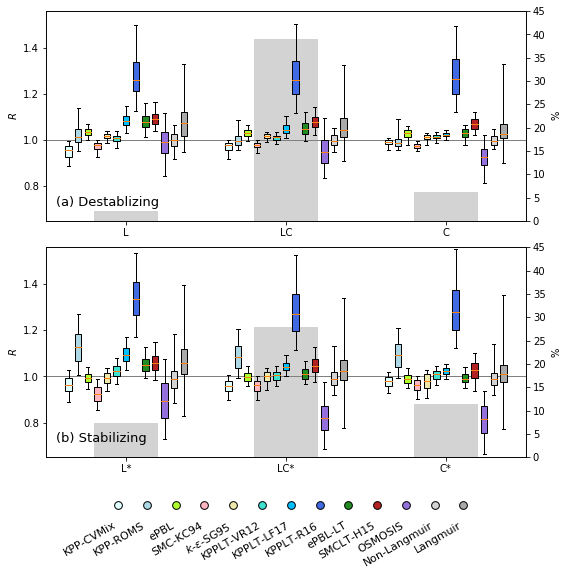

In [15]:
# figure 2b: sort the differences by forcing regime, only including L LC and C

# forcing regimes
pfreg = np.concatenate([gmobj_freg_mon[i].data for i in np.arange(12)])

f, axarr = plt.subplots(2)
f.set_size_inches(8, 8)

# reference line
axarr[0].axhline(y=y_ref, linewidth=1, color='gray')
axarr[1].axhline(y=y_ref, linewidth=1, color='gray')

xshift = list((np.arange(nm+2)-nm/2-1)*0.06+0.03)
pbdata0s0_nlt = []
pbdata0s1_nlt = []
pbdata0s0_lt = []
pbdata0s1_lt = []
for k in np.arange(nm):
    pdata = np.concatenate([gmobj_stat_arr[i][k].data for i in np.arange(12)])
    tmp = pdata
    pfreg0 = pfreg[~np.isnan(tmp)]
    pdata0 = pdata[~np.isnan(tmp)]
    if k == 0:
        pbdata0, hist_pct = mask_forcing_regime(pdata0, pfreg0)
    else:
        pbdata0, tmp = mask_forcing_regime(pdata0, pfreg0)
    xx = np.arange(3)+1
    position_arr = xx+xshift[k]
    pbdata0s0 = [pbdata0[i] for i in [2,10,4]]
    pbox0 = axarr[0].boxplot(pbdata0s0, whis=[5, 95], showfliers=False, 
                             positions=position_arr, widths=0.04, patch_artist=True)
    pbdata0s1 = [pbdata0[i] for i in [3,11,5]]
    pbox1 = axarr[1].boxplot(pbdata0s1, whis=[5, 95], showfliers=False, 
                             positions=position_arr, widths=0.04, patch_artist=True)
    for patch in pbox0['boxes']:
        patch.set_facecolor(bcolor[k])
    for patch in pbox1['boxes']:
        patch.set_facecolor(bcolor[k])
    # save the data for non-Langmuir and Langmuir groups
    if k < 5:
        pbdata0s0_nlt.append(pbdata0s0)
        pbdata0s1_nlt.append(pbdata0s1)
    else:
        pbdata0s0_lt.append(pbdata0s0)
        pbdata0s1_lt.append(pbdata0s1)

# process data for non-Langmuir and Langmuir cases
pbdata1s0_nlt = []
pbdata1s1_nlt = []
pbdata1s0_lt = []
pbdata1s1_lt = []
for k in np.arange(3):
    pbdata0s0 = np.concatenate([pbdata0s0_nlt[i][k] \
                                for i in np.arange(len(pbdata0s0_nlt))])
    pbdata1s0_nlt.append(pbdata0s0)
    pbdata0s1 = np.concatenate([pbdata0s1_nlt[i][k] \
                                for i in np.arange(len(pbdata0s1_nlt))])
    pbdata1s1_nlt.append(pbdata0s1)
    pbdata0s0 = np.concatenate([pbdata0s0_lt[i][k] \
                                for i in np.arange(len(pbdata0s0_lt))])
    pbdata1s0_lt.append(pbdata0s0)
    pbdata0s1 = np.concatenate([pbdata0s1_lt[i][k] \
                                for i in np.arange(len(pbdata0s1_lt))])
    pbdata1s1_lt.append(pbdata0s1)
    
pbcolor = ['lightgray', 'darkgray']
# plot non-Langmuir cases
position_arr = xx+xshift[nm]
pbox0 = axarr[0].boxplot(pbdata1s0_nlt, whis=[5, 95], showfliers=False, 
                         positions=position_arr, widths=0.04, patch_artist=True)
pbox1 = axarr[1].boxplot(pbdata1s1_nlt, whis=[5, 95], showfliers=False, 
                         positions=position_arr, widths=0.04, patch_artist=True)
for patch in pbox0['boxes']:
    patch.set_facecolor(pbcolor[0])
for patch in pbox1['boxes']:
    patch.set_facecolor(pbcolor[0])
# plot Langmuir cases 
position_arr = xx+xshift[nm+1]
pbox0 = axarr[0].boxplot(pbdata1s0_lt, whis=[5, 95], showfliers=False, 
                         positions=position_arr, widths=0.04, patch_artist=True)
pbox1 = axarr[1].boxplot(pbdata1s1_lt, whis=[5, 95], showfliers=False,
                         positions=position_arr, widths=0.04, patch_artist=True)
for patch in pbox0['boxes']:
    patch.set_facecolor(pbcolor[1])
for patch in pbox1['boxes']:
    patch.set_facecolor(pbcolor[1])

# x- and y-labels
plt.setp(axarr[0], xticks=xx, xticklabels=['L', 'LC', 'C'])
plt.setp(axarr[1], xticks=xx, xticklabels=['L*','LC*','C*'])
axarr[0].set_ylabel(y_label)
axarr[1].set_ylabel(y_label)
axarr[0].set_xlim([0.5,np.max(xx)+0.5])
axarr[1].set_xlim([0.5,np.max(xx)+0.5])
axarr[0].set_ylim([ymin,ymax])
axarr[1].set_ylim([ymin,ymax])

# frequency of occurrence
par1 = axarr[0].twinx()
hist_pcts1 = [hist_pct[i] for i in [2,10,4]]
par1.bar(xx, hist_pcts1, width=0.4, color='lightgray')
par1.set_ylabel('$\%$')
par1.set_ylim([0, 45])
axarr[0].set_zorder(par1.get_zorder()+1)
axarr[0].patch.set_visible(False)
# label
axarr[0].text(0.02, 0.12, '(a) Destablizing', fontsize=13, color='k', va='top',
              transform=axarr[0].transAxes)

par2 = axarr[1].twinx()
hist_pcts2 = [hist_pct[i] for i in [3,11,5]]
par2.bar(xx, hist_pcts2, width=0.4, color='lightgray')
par2.set_ylabel('$\%$')
par2.set_ylim([0, 45])
axarr[1].set_zorder(par2.get_zorder()+1)
axarr[1].patch.set_visible(False)
# label
axarr[1].text(0.02, 0.12, '(b) Stabilizing', fontsize=13, color='k', va='top',
              transform=axarr[1].transAxes)

# reduce margin
plt.tight_layout()

# add legend
plt.subplots_adjust(bottom=0.2)
# add color for non-Lanmguir and Langmuir cases
pbcolor = bcolor
pbcolor.append('lightgray')
pbcolor.append('darkgray')
# add label for non-Lanmguir and Langmuir cases
label_list = legend_list
label_list.append('Non-Langmuir')
label_list.append('Langmuir')
# plot
xshift = 0.15
xx = np.arange(nm+2)*0.06+xshift
yy = -np.ones(xx.size)*0.3
for i in np.arange(nm+2):
    axarr[1].text(xx[i], yy[i], legend_list[i], color='black',
                  transform=axarr[1].transAxes, fontsize=11, rotation=30,
                  va='top', ha='right')
    axarr[1].scatter(xx[i], yy[i]+0.07, s=60, c=bcolor[i], edgecolors='k', linewidth=1,
                     transform=axarr[1].transAxes, clip_on=False)

# save figure
figname = fig_root+'/'+fig_prefix+'_'+diagname+'_forc_reg_s.pdf'
plt.savefig(figname, dpi = 300)

# print info
print('Percentage of each regime:')
print('    L: {:6.2f}%,  LC: {:6.2f}%,  C: {:6.2f}%'.format(hist_pcts1[0], hist_pcts1[1], hist_pcts1[2]))
print('   L*: {:6.2f}%, LC*: {:6.2f}%, C*: {:6.2f}%'.format(hist_pcts2[0], hist_pcts2[1], hist_pcts2[2]))
print('Total: {:6.2f}%'.format(sum(hist_pcts1)+sum(hist_pcts2)))

Destablizing:
L:
    Mean: 1.09
    Median: 1.09
    50% range: 1.07 - 1.11
    90% range: 1.02 - 1.17
LC:
    Mean: 1.07
    Median: 1.07
    50% range: 1.04 - 1.09
    90% range: 1.01 - 1.15
C:
    Mean: 1.06
    Median: 1.06
    50% range: 1.04 - 1.08
    90% range: 1.01 - 1.11
Stablizing:
L:
    Mean: 1.08
    Median: 1.08
    50% range: 1.05 - 1.10
    90% range: 1.01 - 1.16
LC:
    Mean: 1.04
    Median: 1.03
    50% range: 1.01 - 1.06
    90% range: 0.99 - 1.10
C:
    Mean: 1.03
    Median: 1.02
    50% range: 1.00 - 1.05
    90% range: 0.98 - 1.09


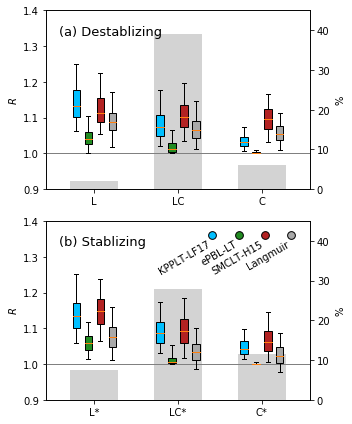

In [16]:
# figure 2c: sort the effects of LT by forcing regime, only including L LC and C

f, axarr = plt.subplots(2)
f.set_size_inches(5, 6)

# add color for non-Lanmguir and Langmuir cases
pbcolor = ['deepskyblue','forestgreen','firebrick','darkgray']
# add label for non-Lanmguir and Langmuir cases
label_list = ['KPPLT-LF17', 'ePBL-LT', 'SMCLT-H15', 'Langmuir']

# reference line
axarr[0].axhline(y=y_ref, linewidth=1, color='gray')
axarr[1].axhline(y=y_ref, linewidth=1, color='gray')

xshift = list((np.arange(4)-2)*0.10+0.05)

# forcing regimes
pfreg = np.concatenate([gmobj_freg_mon[i].data for i in np.arange(12)])

gmobj_list = []
# Langmuir effects in KPP
gmobj_list.append(gmobj_m_mon_kpp)
# Langmuir effects in ePBL
gmobj_list.append(gmobj_m_mon_epbl)
# Langmuir effects in SMC
gmobj_list.append(gmobj_m_mon_smc)
# mean of the Langmuir cases
gmobj_list.append(gmobj_m_mon_lt)
    
for k in np.arange(4):
    pdata = np.concatenate([gmobj_list[k][i].data for i in np.arange(12)])
    tmp = pdata
    pfreg0 = pfreg[~np.isnan(tmp)]
    pdata0 = pdata[~np.isnan(tmp)]
    pbdata0, tmp = mask_forcing_regime(pdata0, pfreg0)
    xx = (np.arange(3)+1)*0.7
    position_arr = xx+xshift[k]
    pbdata0s0 = [pbdata0[i] for i in [2,10,4]]
    pbox0 = axarr[0].boxplot(pbdata0s0, whis=[5, 95], showfliers=False, 
                             positions=position_arr, widths=0.06, patch_artist=True)
    pbdata0s1 = [pbdata0[i] for i in [3,11,5]]
    pbox1 = axarr[1].boxplot(pbdata0s1, whis=[5, 95], showfliers=False, 
                             positions=position_arr, widths=0.06, patch_artist=True)
    for patch in pbox0['boxes']:
        patch.set_facecolor(pbcolor[k])
    for patch in pbox1['boxes']:
        patch.set_facecolor(pbcolor[k])

# x- and y-labels
plt.setp(axarr[0], xticks=xx, xticklabels=['L', 'LC', 'C'])
plt.setp(axarr[1], xticks=xx, xticklabels=['L*','LC*','C*'])
axarr[0].set_ylabel(y_label)
axarr[1].set_ylabel(y_label)
axarr[0].set_xlim([0.3,np.max(xx)+0.4])
axarr[1].set_xlim([0.3,np.max(xx)+0.4])
if diag_type == 'R':
    ymin1 = 0.9
    ymax1 = 1.4
elif diag_type == 'D':
    ymin1 = -5
    ymax1 = 35
    
axarr[0].set_ylim([ymin1,ymax1])
axarr[1].set_ylim([ymin1,ymax1])

# frequency of occurrence
par1 = axarr[0].twinx()
hist_pcts1 = [hist_pct[i] for i in [2,10,4]]
par1.bar(xx, hist_pcts1, width=0.4, color='lightgray')
par1.set_ylabel('$\%$')
par1.set_ylim([0, 45])
axarr[0].set_zorder(par1.get_zorder()+1)
axarr[0].patch.set_visible(False)
# label
axarr[0].text(0.05, 0.92, '(a) Destablizing', transform=axarr[0].transAxes,
              fontsize=13, color='k', va='top')

par2 = axarr[1].twinx()
hist_pcts2 = [hist_pct[i] for i in [3,11,5]]
par2.bar(xx, hist_pcts2, width=0.4, color='lightgray')
par2.set_ylabel('$\%$')
par2.set_ylim([0, 45])
axarr[1].set_zorder(par2.get_zorder()+1)
axarr[1].patch.set_visible(False)
# label
axarr[1].text(0.05, 0.92, '(b) Stablizing', transform=axarr[1].transAxes,
              fontsize=13, color='k', va='top')


# legend
xshift = 0.63
xx = np.arange(4)
xx = xx*0.1+xshift
yy = np.ones(xx.size)*0.90
for i in np.arange(4):
    axarr[1].text(xx[i], yy[i], label_list[i], color='black', 
                  transform=axarr[1].transAxes, fontsize=10, rotation=30,
                  va='top', ha='right')
    axarr[1].scatter(xx[i], 0.92, s=60, c=pbcolor[i], edgecolors='k',
                     linewidth=1, transform=axarr[1].transAxes)

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/'+fig_prefix+'_'+diagname+'_forc_reg_s_c.pdf'
plt.savefig(figname, dpi = 300)

# print info
print('Destablizing:')
medians_arr = [item.get_ydata() for item in pbox0['medians']]
whiskers_arr = [item.get_ydata() for item in pbox0['whiskers']]
for i, var in enumerate(['L', 'LC', 'C']):
    print('{}:'.format(var))
    print('    Mean: {:4.2f}'.format(pbdata0s0[i].mean()))
    print('    Median: {:4.2f}'.format(medians_arr[i][0]))
    ii = i*2
    print('    50% range: {:4.2f} - {:4.2f}'.format(whiskers_arr[ii][0], whiskers_arr[ii+1][0]))
    print('    90% range: {:4.2f} - {:4.2f}'.format(whiskers_arr[ii][1], whiskers_arr[ii+1][1]))
print('Stablizing:')
medians_arr = [item.get_ydata() for item in pbox1['medians']]
whiskers_arr = [item.get_ydata() for item in pbox1['whiskers']]
for i, var in enumerate(['L', 'LC', 'C']):
    print('{}:'.format(var))
    print('    Mean: {:4.2f}'.format(pbdata0s1[i].mean()))
    print('    Median: {:4.2f}'.format(medians_arr[i][0]))
    ii = i*2
    print('    50% range: {:4.2f} - {:4.2f}'.format(whiskers_arr[ii][0], whiskers_arr[ii+1][0]))
    print('    90% range: {:4.2f} - {:4.2f}'.format(whiskers_arr[ii][1], whiskers_arr[ii+1][1]))

In [17]:
def mask_latitude(pdata, lat):
    hist = np.zeros(7)
    pdata_S3 = pdata[lat<=-50]
    hist[0]  = pdata_S3.size
    pdata_S2 = pdata[(lat>-50) & (lat<=-30)]
    hist[1]  = pdata_S2.size
    pdata_S1 = pdata[(lat>-30) & (lat<=-10)]
    hist[2]  = pdata_S1.size
    pdata_EQ = pdata[(lat>-10) & (lat<10)]
    hist[3]  = pdata_EQ.size
    pdata_N1 = pdata[(lat>=10) & (lat<30)]
    hist[4]  = pdata_N1.size
    pdata_N2 = pdata[(lat>=30) & (lat<50)]
    hist[5]  = pdata_N2.size
    pdata_N3 = pdata[lat>=50]
    hist[6]  = pdata_N3.size
    masked_data = [pdata_S3, pdata_S2, pdata_S1, pdata_EQ, pdata_N1, pdata_N2, pdata_N3]
    hist_pct = hist/np.sum(hist)*100
    return masked_data, hist_pct

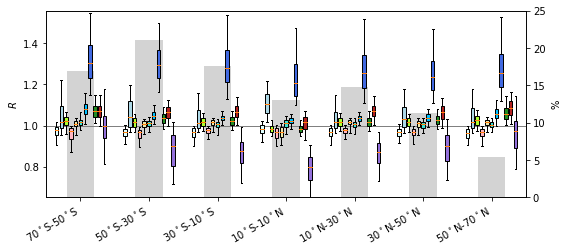

In [18]:
# figure 3: sort the differences by latitude

plat = np.concatenate([gmobj_m_mon_nlt[i].lat for i in np.arange(12)])

f = plt.figure()
f.set_size_inches(8, 3.5)

# reference line
plt.axhline(y=y_ref, linewidth=1, color='gray')

xshift = list((np.arange(nm)-nm/2)*0.07+0.035)
for k in np.arange(nm):
    pdata = np.concatenate([gmobj_stat_arr[i][k].data for i in np.arange(12)])
    tmp = pdata
    plat0 = plat[~np.isnan(tmp)]
    pdata0 = pdata[~np.isnan(tmp)]
    pbdata0, hist_pct = mask_latitude(pdata0, plat0)
    xx = np.arange(hist_pct.size)+1
    position_arr = xx+xshift[k]
    pbox0 = plt.boxplot(pbdata0, whis=[5, 95], showfliers=False, positions=position_arr,
                             widths=0.05, patch_artist=True)
    for patch in pbox0['boxes']:
        patch.set_facecolor(bcolor[k])

# x- and y-labels
ax = plt.gca()
plt.setp(ax, xticks=xx, xticklabels=['70$^\circ$S-50$^\circ$S',
                                     '50$^\circ$S-30$^\circ$S',
                                     '30$^\circ$S-10$^\circ$S',
                                     '10$^\circ$S-10$^\circ$N',
                                     '10$^\circ$N-30$^\circ$N',
                                     '30$^\circ$N-50$^\circ$N',
                                     '50$^\circ$N-70$^\circ$N'])
plt.ylabel(y_label)
plt.xlim([0.5,np.max(xx)+0.5])
plt.ylim([ymin,ymax])

# frequency of occurrence
par1 = ax.twinx()
par1.bar(xx, hist_pct, width=0.4, color='lightgray')
par1.set_ylabel('$\%$')
par1.set_ylim([0, 25])
ax.set_zorder(par1.get_zorder()+1)
ax.patch.set_visible(False)

# reduce margin
plt.tight_layout()

# auto adjust the x-axis label
plt.gcf().autofmt_xdate()

# save figure
figname = fig_root+'/'+fig_prefix+'_'+diagname+'_lat.png'
plt.savefig(figname, dpi = 300)

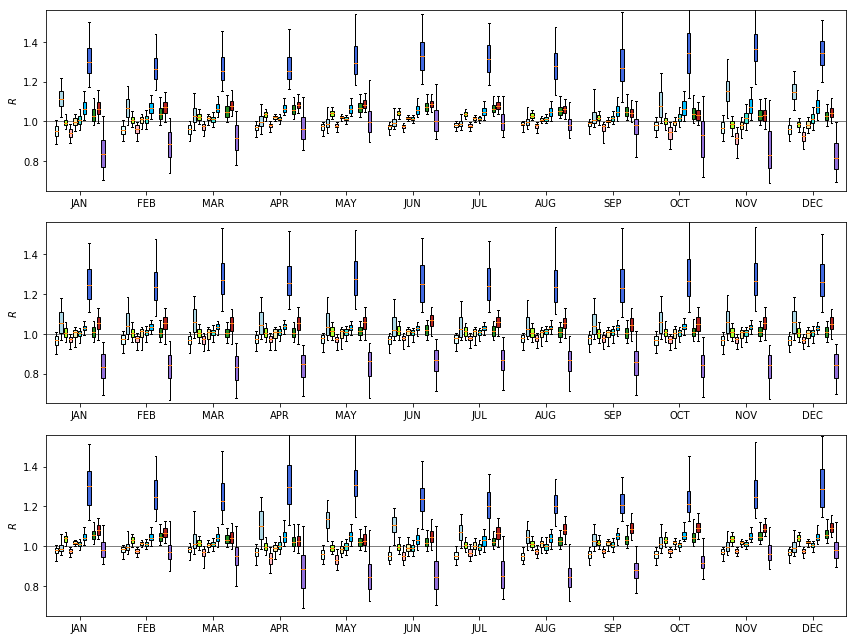

In [19]:
# figure 4: sort the differences by month

f, axarr = plt.subplots(3)
f.set_size_inches(12, 9)

# reference line
axarr[0].axhline(y=y_ref, linewidth=1, color='gray')
axarr[1].axhline(y=y_ref, linewidth=1, color='gray')
axarr[2].axhline(y=y_ref, linewidth=1, color='gray')

xx = np.arange(12)+1
xshift = list((np.arange(nm)-nm/2)*0.07+0.035)
for k in np.arange(nm):
    pbdata0 = []
    pbdata1 = []
    pbdata2 = []
    for i in np.arange(12):
        plat = gmobj_stat_arr[i][k].lat
        # south of 30S
        pdata = gmobj_stat_arr[i][k].data[plat<=-30]
        pdata = pdata[~np.isnan(pdata)]
        pbdata0.append(pdata)
        # 30S-30N
        pdata = gmobj_stat_arr[i][k].data[(plat>-30) & (plat<30)]
        pdata = pdata[~np.isnan(pdata)]
        pbdata1.append(pdata)
        # north of 30N
        pdata = gmobj_stat_arr[i][k].data[plat>=30]
        pdata = pdata[~np.isnan(pdata)]
        pbdata2.append(pdata)
    position_arr = xx+xshift[k]
    pbox0 = axarr[0].boxplot(pbdata0, whis=[5, 95], showfliers=False,
                             positions=position_arr, widths=0.05, patch_artist=True)
    pbox1 = axarr[1].boxplot(pbdata1, whis=[5, 95], showfliers=False,
                             positions=position_arr, widths=0.05, patch_artist=True)
    pbox2 = axarr[2].boxplot(pbdata2, whis=[5, 95], showfliers=False,
                             positions=position_arr, widths=0.05, patch_artist=True)
    for patch in pbox0['boxes']:
        patch.set_facecolor(bcolor[k])
    for patch in pbox1['boxes']:
        patch.set_facecolor(bcolor[k])
    for patch in pbox2['boxes']:
        patch.set_facecolor(bcolor[k])

# x- and y-labels
month_labels = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', \
                'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
plt.setp(axarr[0], xticks=xx, xticklabels=month_labels)
plt.setp(axarr[1], xticks=xx, xticklabels=month_labels)
plt.setp(axarr[2], xticks=xx, xticklabels=month_labels)
axarr[0].set_ylabel(y_label)
axarr[1].set_ylabel(y_label)
axarr[2].set_ylabel(y_label)
axarr[0].set_xlim([0.5,np.max(xx)+0.5])
axarr[1].set_xlim([0.5,np.max(xx)+0.5])
axarr[2].set_xlim([0.5,np.max(xx)+0.5])
axarr[0].set_ylim([ymin,ymax])
axarr[1].set_ylim([ymin,ymax])
axarr[2].set_ylim([ymin,ymax])

# reduce margin
plt.tight_layout()

# save figure
figname = fig_root+'/'+fig_prefix+'_'+diagname+'_mon.png'
plt.savefig(figname, dpi = 300)